In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sl

In [91]:
# Setup Parameters
x_min = 0.
x_max = 100.
n_x = 500
dt = 0.01

x_0 = x_min + (x_max - x_min) / 2
p_0 = 1.
sig = 0.04

X = x_mesh = np.linspace(x_min, x_max, n_x)
dx = x_mesh[1] - x_mesh[0]
pi = np.pi

In [92]:
# Useful Functions
def normalization(wf: np.ndarray) -> np.ndarray:
    return wf / np.linalg.norm(wf)

def get_prob(wf: np.ndarray) -> np.ndarray:
    return np.abs(wf) ** 2

def overlap(f1: np.ndarray, f2: np.ndarray) -> float:
    return np.abs(np.dot(np.conj(f1), f2)) ** 2

class CrankNicolson:
    def __init__(self):
        dim = self.dim = len(X)
        diag = -2 * np.ones(dim)
        diag[0] = diag[-1] = 1
        diag *= -0.5 * dt / dx ** 2
        upper = np.ones(dim) * (-0.5 * dt / dx ** 2)
        upper[0] = upper[1] = 0
        lower = np.ones(dim) * (-0.5 * dt / dx ** 2)
        lower[-1] = lower[-2] = 0
        self.Hdt = sp.dia_matrix(([diag, upper, lower], [0, 1, -1]), shape=(dim, dim), dtype=np.complex128)
    
    def next(self, psi: np.ndarray) -> np.ndarray:
        dim = self.dim
        Hdt = self.Hdt
        b = (sp.eye(dim) - 1.j * Hdt / 2).dot(psi)
        A = (sp.eye(dim) + 1.j * Hdt / 2).tocsc()
        return sl.spsolve(A, b)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolv:
    # Debug!
    def __init__(self, inter: int=1, cutoff: int=1):
        self.dx = dx
        self.dk = 2 * np.pi / ((x_max - x_min) * inter)
        self.p = inter
        self.kmesh = kmesh_ele = np.arange(len(X) * inter)
        for i in range(cutoff):
            self.kmesh = np.append(self.kmesh, kmesh_ele * i)
            
        self.kmesh = np.append(self.kmesh[-1:0:-1], self.kmesh)
        self.kmesh = self.kmesh * self.dk
        self.indl = {(s, l): np.arange(l * len(X) + s, l * len(X) + len(X) * inter, inter) for l in range(-cutoff, cutoff+1) for s in range(inter)}
        
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt / 2)
    
    def cft(self, x: np.ndarray) -> np.ndarray:
        x_re = np.real(x)
        x_im = np.imag(x)
        res = np.zeros(len(self.kmesh), dtype=np.complex128)
        cache_fft = {}
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.fft.fft(np.exp(-1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p)) * x)
            res[indl] = cache_fft[s]
        res = np.exp(-1.j * self.kmesh * x_min) * res
        return res
    
    def cft_inv(self, x: np.ndarray) -> np.ndarray:
        x = np.exp(1.j * self.kmesh * x_min) * x
        cache_fft = {}
        res = np.zeros(len(X), dtype=np.complex128)
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.exp(1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p))
            res += cache_fft[s] * np.fft.ifft(x[indl])
        
        return res

    def next(self, psi: np.ndarray) -> np.ndarray:
        fac = self.dx * self.dk / (2 * pi)
        x = self.cft_inv(self.dyna_phase * self.cft(psi))
        return normalization(x)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolvRough:
    def __init__(self):
        # self.dx = dx
        self.kmesh = np.fft.fftfreq(len(X)) / dx * 2 * pi
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt/2)
        
    def next(self, psi:np.ndarray) -> np.ndarray:
        psi_moment = np.fft.fft(psi)
        return normalization(np.fft.ifft(psi_moment * self.dyna_phase))
    
    def __call__(self, x:np.ndarray) -> np.ndarray:
        return self.next(x)

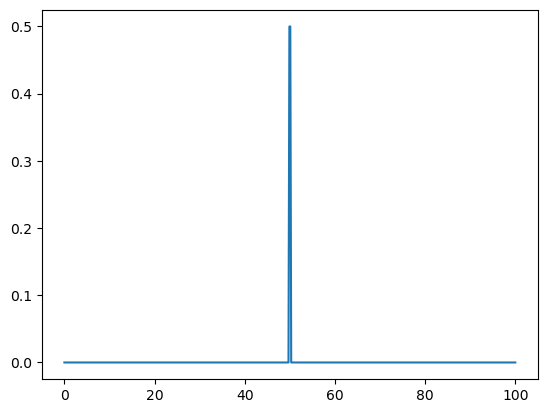

Crank_Nicolson: 1.0000000000000004	FFT: 1.0000000000000004	Overlap: 1.0000000000000004


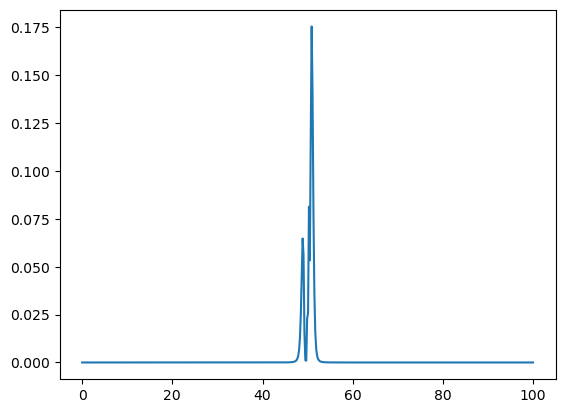

Crank_Nicolson: 1.0000000000000024	FFT: 0.9999999999999999	Overlap: 0.1195873348751049


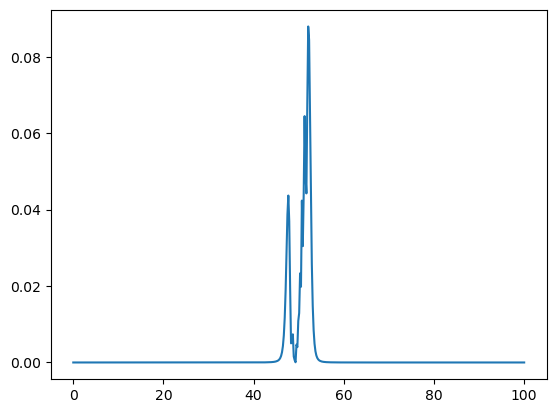

Crank_Nicolson: 1.000000000000005	FFT: 0.9999999999999998	Overlap: 0.07093447768236792


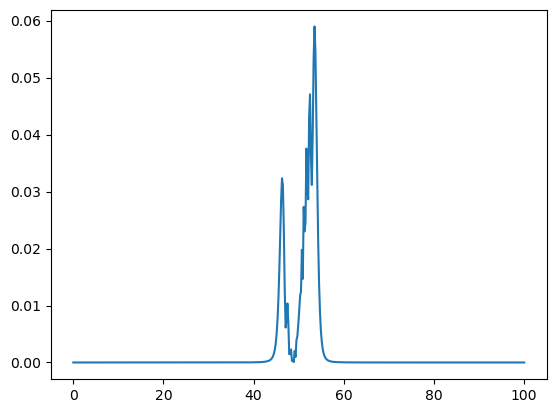

Crank_Nicolson: 1.0000000000000087	FFT: 1.0	Overlap: 0.04279386347694707


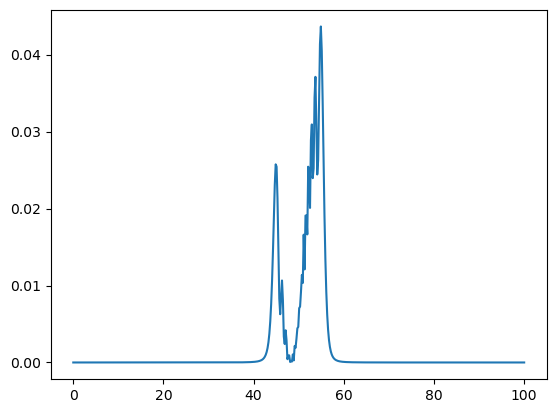

Crank_Nicolson: 1.000000000000011	FFT: 1.0000000000000004	Overlap: 0.027106594989379975


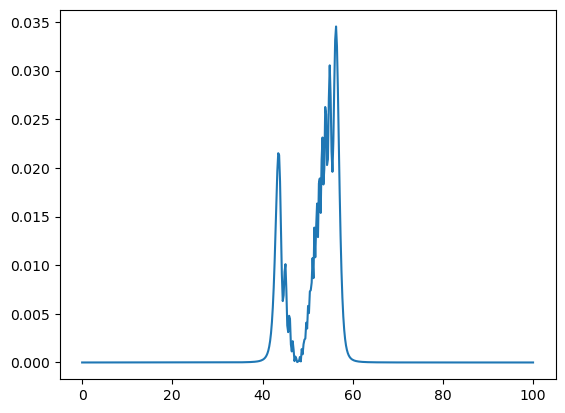

Crank_Nicolson: 1.0000000000000144	FFT: 1.0	Overlap: 0.021851783808298067


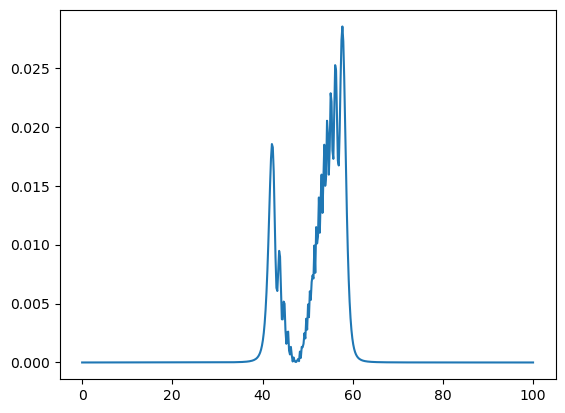

Crank_Nicolson: 1.000000000000018	FFT: 0.9999999999999992	Overlap: 0.0220469462739935


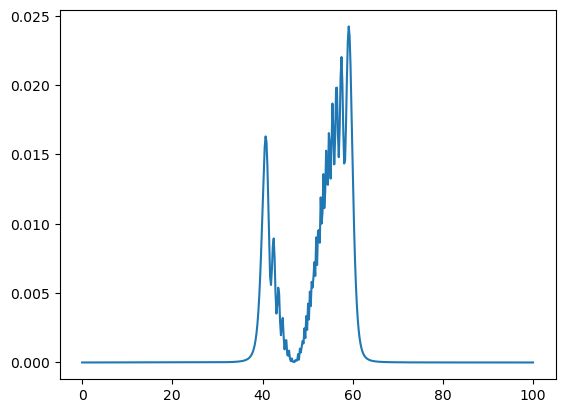

Crank_Nicolson: 1.0000000000000207	FFT: 1.0	Overlap: 0.02225235208351709


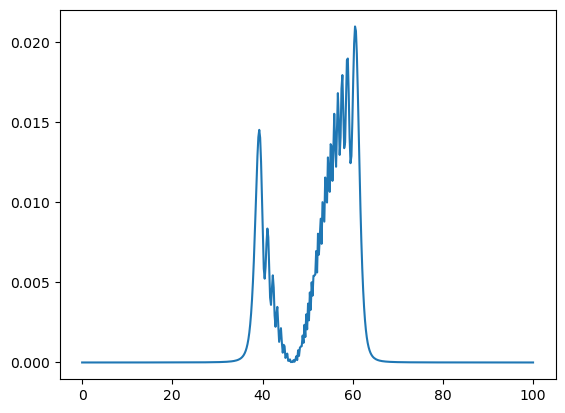

Crank_Nicolson: 1.0000000000000235	FFT: 1.0	Overlap: 0.02003807865526396


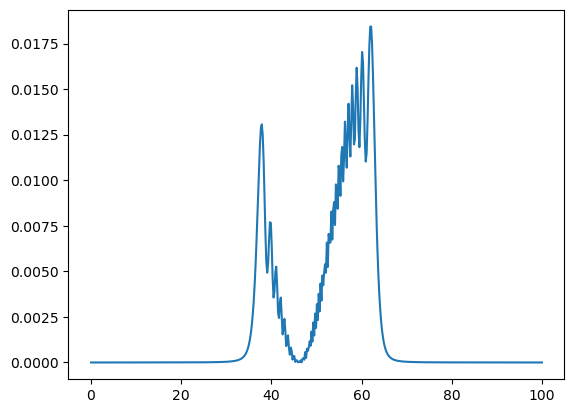

Crank_Nicolson: 1.0000000000000269	FFT: 0.9999999999999999	Overlap: 0.01653507900619433


In [93]:
# Initialization

p_0 = 20

ini_psi = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) - 1.j * (X - x_0) * p_0))
ini_psi_op = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) + 1.j * (X - x_0) * p_0))

# Dynamics

import matplotlib.pyplot as plt

cn_solver = CrankNicolson()
# ft_solver = FFTSolv(inter=50, cutoff=2)
ft_solver = FFTSolvRough()
psi1 = ini_psi
psi2 = ini_psi
for i in range(100):
    p1 = get_prob(psi1)
    p2 = get_prob(psi2)
    if i % 10 == 0:
        plt.plot(X, p1)
        plt.show()
    
        print(f"Crank_Nicolson: {sum(p1)}\tFFT: {sum(p2)}\tOverlap: {overlap(psi1, psi2)}")
    # print(f"<X>: {sum(p1 * X), sum(p2 * X)}\t<v>: {sum((p1-p2) * X) / (i+1)}")
    
    psi1 = cn_solver(psi1)
    psi2 = ft_solver(psi2)
    
    
    psi1[0] = psi1[-1] = 0
    psi2[0] = psi2[-1] = 0
    psi2 = normalization(psi2)
    

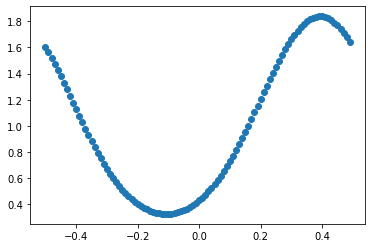

In [142]:
plt.scatter(np.fft.fftfreq(len(X)), get_prob(np.fft.fft(ini_psi)))

In [7]:
ft_solver = FFTSolv(inter=50, cutoff=5)
print(ft_solver.dk)

0.012566370614359173


In [64]:
np.fft.fftfreq(10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

In [84]:
np.real(cn_solver.Hdt.toarray())

array([[-1.245005,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-1.245005,  2.49001 , -1.245005, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , -1.245005,  2.49001 , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  2.49001 , -1.245005,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., -1.245005,  2.49001 ,
        -1.245005],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
        -1.245005]])